# Компʼютерний практикум №13
Виконав студент групи ЗК-41мп Гломозда Костянтин

АРХІТЕКТУРА GOOGLE NET

Результати кращої мережі попередньої роботи (CIFAR10):

Model resnet20_d_out p=0.15, accuracy: 0.84

Load data

In [1]:
import torch
import torchvision.datasets
import numpy as np
import time
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

CIFAR_train = torchvision.datasets.CIFAR10('./data', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./data', download=True, train=False)
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

X_train /= 255.
X_test /= 255.

Files already downloaded and verified
Files already downloaded and verified


Visualize

tensor(6) tensor(9) tensor(9) tensor(4) tensor(1) tensor(1) tensor(2) tensor(7) tensor(8) tensor(3) 

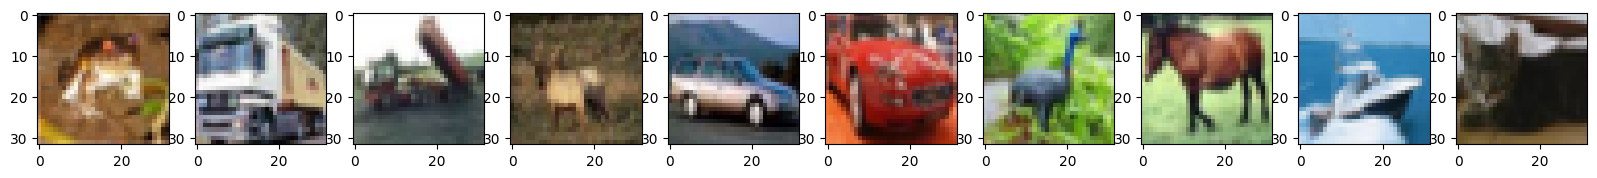

In [2]:
plt.figure(figsize=(20, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')
plt.show()

Prepare data

In [3]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

Train func

In [4]:
def train(net, X_train, y_train, X_test, y_test, batch_size=256,
          epoch_num=50, epoch_info_show=10, weight_decay=0,
          save_net_state=False, verbose=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3, weight_decay=weight_decay)
    t = time.time()
    test_accuracy_history = []
    test_loss_history = []
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(1, epoch_num + 1):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()
            batch_indexes = order[start_index:start_index + batch_size]
            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)
            preds = net.forward(X_batch)

            if isinstance(preds, tuple):  # For GoogLeNet with aux outputs
                main_pred, aux2_pred, aux1_pred = preds
                loss_main = loss(main_pred, y_batch)
                loss_aux2 = loss(aux2_pred, y_batch)
                loss_aux1 = loss(aux1_pred, y_batch)
                loss_value = loss_main + 0.3 * loss_aux2 + 0.3 * loss_aux1
            else:
                loss_value = loss(preds, y_batch)

            loss_value.backward()
            optimizer.step()

        net.eval()
        with torch.no_grad():
            test_preds = net.forward(X_test)
            if isinstance(test_preds, tuple):
                test_preds = test_preds[0]
            loss_value = loss(test_preds, y_test).item()
            test_loss_history.append(loss_value)
            accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()
            test_accuracy_history.append(accuracy)
            if verbose and epoch % epoch_info_show == 0:
                print(f'Train Epoch: {epoch} Time: {time.strftime("%H:%M:%S", time.gmtime(time.time() - t))} Accuracy: {accuracy}')

    net_state = net.state_dict()
    if save_net_state:
        return test_accuracy_history, test_loss_history, net_state
    else:
        return test_accuracy_history, test_loss_history


Visualize

In [5]:
sns.set_style("darkgrid")
sns.set_theme(rc={'figure.figsize':(15, 6)})
def acc_loss_graph(accuracies, losses, net_list,
    save_file_name='plot.png', download=False):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    for experiment_id in net_list:
        ax1.plot(accuracies[experiment_id], label=experiment_id)
        
    ax1.legend()
    ax1.set_title('Validation Accuracy')
    fig.tight_layout()
    for experiment_id in net_list:
        ax2.plot(losses[experiment_id], label=experiment_id)
        
    ax2.legend()
    ax2.set_title('Validation Loss')
    fig.tight_layout()
    if download:
        fig.savefig(save_file_name)

Google Net

In [6]:
import torch
import torch.nn as nn


class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1, y2, y3, y4], 1)

class InceptionAux(nn.Module):
    def __init__(self, in_planes, num_classes):
        super(InceptionAux, self).__init__()
        self.conv = nn.Conv2d(in_planes, 128, kernel_size=1)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = torch.nn.functional.adaptive_avg_pool2d(x, (4, 4))
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = torch.nn.functional.relu(self.fc1(x), inplace=True)
        x = torch.nn.functional.dropout(x, 0.7, training=self.training)
        x = self.fc2(x)
        return x

class GoogLeNet(nn.Module):
    def __init__(self, num_classes=10, aux_logits=True):
        super(GoogLeNet, self).__init__()
        self.aux_logits = aux_logits
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, padding=3, stride=2),
            nn.MaxPool2d(3, stride=2, ceil_mode=True),
            nn.Conv2d(64, 64, kernel_size=1),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.MaxPool2d(3, stride=2, ceil_mode=True),
        )
        self.a3 = Inception(192, 64, 96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        self.a4 = Inception(480, 192, 96, 208, 16, 48, 64)
        self.b4 = Inception(512, 160, 112, 224, 24, 64, 64)
        self.c4 = Inception(512, 128, 128, 256, 24, 64, 64)
        self.d4 = Inception(512, 112, 144, 288, 32, 64, 64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)
        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)
        
        if aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pre_layers(x)
        x = self.a3(x)
        x = self.b3(x)
        x = self.maxpool(x)
        x = self.a4(x)
        aux1 = self.aux1(x) if (self.training and self.aux_logits) else None
        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        aux2 = self.aux2(x) if (self.training and self.aux_logits) else None
        x = self.e4(x)
        x = self.maxpool(x)
        x = self.a5(x)
        x = self.b5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.linear(x)
        return (x, aux2, aux1) if self.training and self.aux_logits else x

Train and visualize

In [7]:
accuracies, losses = {}, {}

accuracies['googlenet_custom'], losses['googlenet_custom'] = \
    train(GoogLeNet(num_classes=10, aux_logits=True), \
          X_train, y_train, X_test, y_test, epoch_num=50, epoch_info_show=5)

Train Epoch: 5 Time: 00:00:12 Accuracy: 0.647599995136261
Train Epoch: 10 Time: 00:00:27 Accuracy: 0.7215999960899353
Train Epoch: 15 Time: 00:00:40 Accuracy: 0.7336999773979187
Train Epoch: 20 Time: 00:00:54 Accuracy: 0.7386999726295471
Train Epoch: 25 Time: 00:01:07 Accuracy: 0.7275999784469604
Train Epoch: 30 Time: 00:01:19 Accuracy: 0.7216999530792236
Train Epoch: 35 Time: 00:01:33 Accuracy: 0.765999972820282
Train Epoch: 40 Time: 00:01:45 Accuracy: 0.7562999725341797
Train Epoch: 45 Time: 00:01:58 Accuracy: 0.738599956035614
Train Epoch: 50 Time: 00:02:11 Accuracy: 0.7590999603271484


По результатам бачимо, що мережа має достатньо високу точність. Тепер спробуємо використати готову googlenet

In [8]:
from torchvision.models import googlenet
import torch


accuracies['googlenet_pytorch'], losses['googlenet_pytorch'] = \
    train(googlenet(pretrained=False, num_classes=10, aux_logits=True), \
        X_train, y_train, X_test, y_test, epoch_num=50, epoch_info_show=5)

/home/dynokostya/Documents/Projects/nn-pytorch-labs/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dynokostya/Documents/Projects/nn-pytorch-labs/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/dynokostya/Documents/Projects/nn-pytorch-labs/.venv/lib/python3.12/site-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Train Epoch: 5 Time: 00:00:11 Accuracy: 0.6725999712944031
Train Epoch: 10 Time: 00:00:23 Accuracy: 0.683899998664856


Train Epoch: 15 Time: 00:00:34 Accuracy: 0.741599977016449
Train Epoch: 20 Time: 00:00:45 Accuracy: 0.7495999932289124
Train Epoch: 25 Time: 00:00:57 Accuracy: 0.7587999701499939
Train Epoch: 30 Time: 00:01:09 Accuracy: 0.7547999620437622
Train Epoch: 35 Time: 00:01:23 Accuracy: 0.773099958896637
Train Epoch: 40 Time: 00:01:34 Accuracy: 0.7640999555587769
Train Epoch: 45 Time: 00:01:47 Accuracy: 0.7645999789237976
Train Epoch: 50 Time: 00:02:00 Accuracy: 0.733199954032898


Improve googlenet:
- Dropout
- Regularization
- modify aux

In [9]:
import torch
import torch.nn as nn

class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),  # Added batch normalization
            nn.ReLU(True),
        )
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1, y2, y3, y4], 1)

class InceptionAux(nn.Module):
    def __init__(self, in_planes, num_classes):
        super(InceptionAux, self).__init__()
        self.conv = nn.Conv2d(in_planes, 128, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(128)  # Added batch normalization to auxiliary classifier
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        x = torch.nn.functional.adaptive_avg_pool2d(x, (4, 4))
        x = self.conv(x)
        x = self.bn1(x)
        x = torch.flatten(x, 1)
        x = torch.nn.functional.relu(self.fc1(x), inplace=True)
        x = torch.nn.functional.dropout(x, 0.5, training=self.training)  # Reduced dropout for better gradient flow
        x = self.fc2(x)
        return x

class ImprovedGoogLeNet(nn.Module):
    def __init__(self, num_classes=10, aux_logits=True):
        super(ImprovedGoogLeNet, self).__init__()
        self.aux_logits = aux_logits
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, padding=3, stride=2),
            nn.BatchNorm2d(64),  # Added batch normalization to the first conv layer
            nn.ReLU(True),
            nn.MaxPool2d(3, stride=2, ceil_mode=True),
            nn.Conv2d(64, 64, kernel_size=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
            nn.MaxPool2d(3, stride=2, ceil_mode=True),
        )
        self.a3 = Inception(192, 64, 96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        self.a4 = Inception(480, 192, 96, 208, 16, 48, 64)
        self.b4 = Inception(512, 160, 112, 224, 24, 64, 64)
        self.c4 = Inception(512, 128, 128, 256, 24, 64, 64)
        self.d4 = Inception(512, 112, 144, 288, 32, 64, 64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)
        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        if aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)  # Increased dropout before the final layer
        self.linear = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pre_layers(x)
        x = self.a3(x)
        x = self.b3(x)
        x = self.maxpool(x)
        x = self.a4(x)
        aux1 = self.aux1(x) if (self.training and self.aux_logits) else None
        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        aux2 = self.aux2(x) if (self.training and self.aux_logits) else None
        x = self.e4(x)
        x = self.maxpool(x)
        x = self.a5(x)
        x = self.b5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.linear(x)
        return (x, aux2, aux1) if self.training and self.aux_logits else x

Train

In [10]:
accuracies['googlenet_improved'], losses['googlenet_improved'] = train(
    ImprovedGoogLeNet(num_classes=10, aux_logits=True),
    X_train, y_train, X_test, y_test, epoch_num=50, epoch_info_show=5
)

Train Epoch: 5 Time: 00:00:14 Accuracy: 0.6222999691963196
Train Epoch: 10 Time: 00:00:27 Accuracy: 0.7166000008583069
Train Epoch: 15 Time: 00:00:40 Accuracy: 0.7252999544143677
Train Epoch: 20 Time: 00:00:53 Accuracy: 0.7324000000953674
Train Epoch: 25 Time: 00:01:05 Accuracy: 0.7408999800682068
Train Epoch: 30 Time: 00:01:18 Accuracy: 0.7562999725341797
Train Epoch: 35 Time: 00:01:31 Accuracy: 0.7549999952316284
Train Epoch: 40 Time: 00:01:45 Accuracy: 0.7645999789237976
Train Epoch: 45 Time: 00:01:58 Accuracy: 0.7622999548912048
Train Epoch: 50 Time: 00:02:12 Accuracy: 0.7744999527931213


Compare all

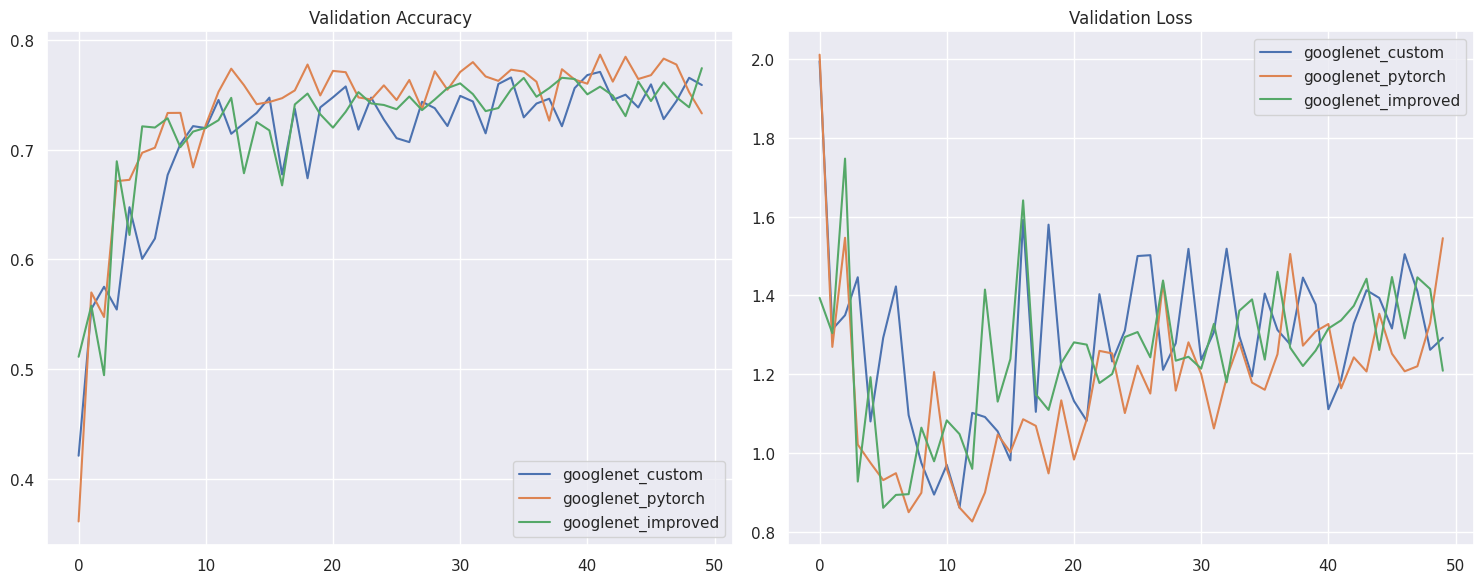

In [11]:
acc_loss_graph(accuracies, losses, ['googlenet_custom', 'googlenet_pytorch', 'googlenet_improved'])

Візьмемо результати з минулої роботи

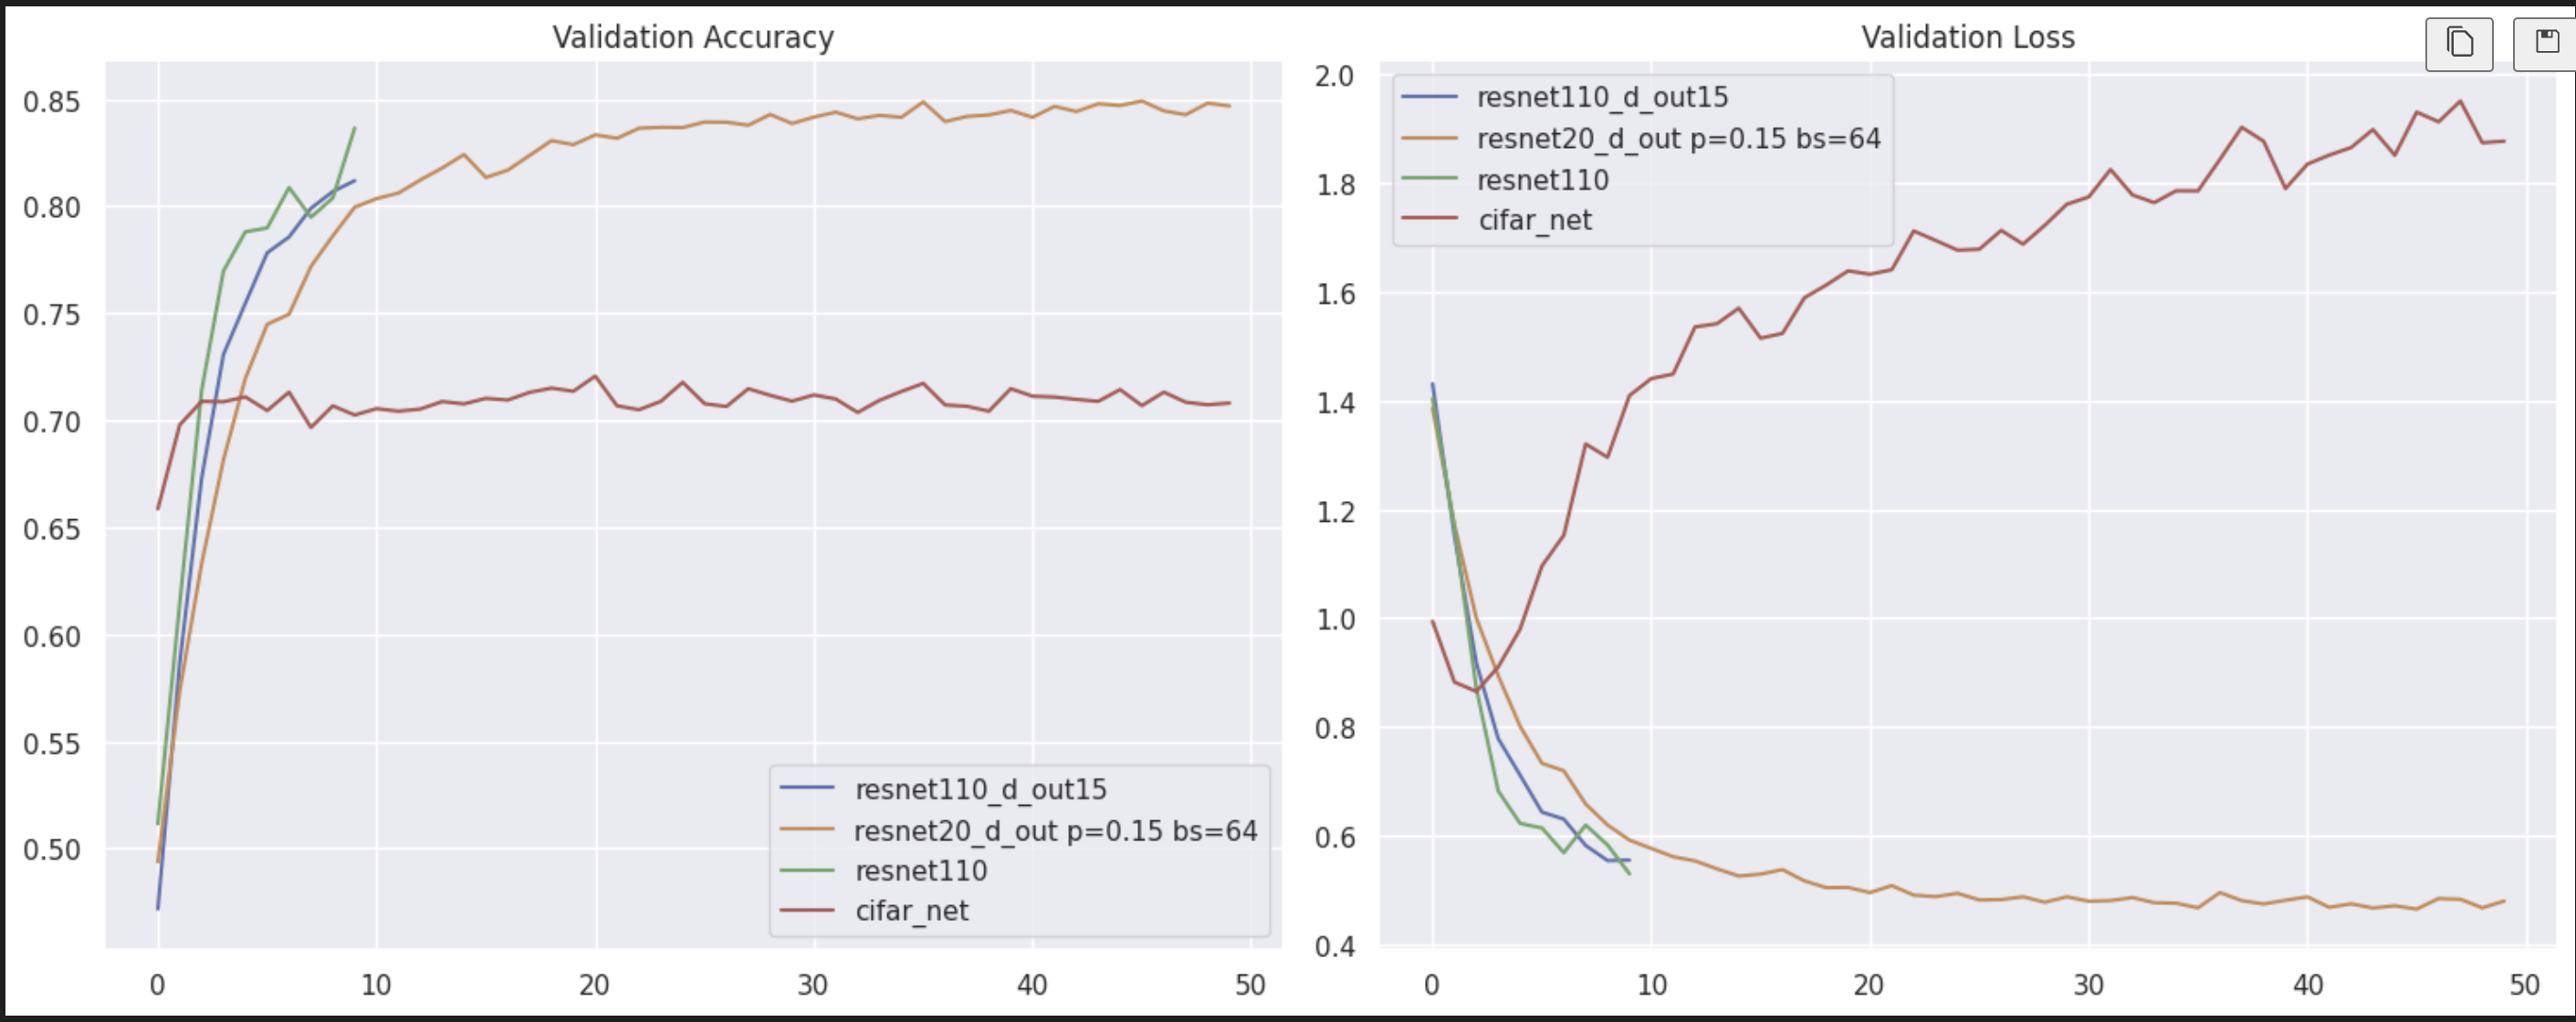

Висновки:

1. Покращена googlenet показала кращі результати, ніж початкова версія.
2. Готові моделі є найоптимальнішим вибором.
3. За необхідністю можна використати і покращену модель.
4. ResNet20 dp=0.15 bs=64 все ще показує більш стабільне навчання. Але для вибору між googlenet та resnet бажано робити додаткові перевірки для визначення перенавчання нейромереж.

Контрольні запитання
1. Які особливості архітектури Google Net?
2. Що являє собою Inception block?

1. GoogleNet, також відома як Inception, має 22 шари в глибину і оптимізовану структуру, що значно зменшує кількість параметрів до 4 мільйонів порівняно з AlexNet, яка мала 60 мільйонів. Архітектура використовує Inception-блоки для обробки інформації на різних масштабах одночасно, що забезпечує ефективне витягування ознак, і містить допоміжні виходи для покращення градієнтного сигналу при навчанні.
2. Inception block — це основний компонент GoogleNet, що складається з кількох паралельних шарів, які виконують згортки з різними розмірами ядер (1x1, 3x3, 5x5) та pooling, дозволяючи мережі захоплювати як локальні, так і глобальні ознаки в одному шарі.